# Create graphiz visualisation

> This module creates the workflow visualisation based on the instances and using the `graphiz` module.

In [ ]:
#| default_exp viz

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import graphviz
from infoflow.classdb import *
from infoflow.creinst import *

## Helper functions

The function `get_items_for_tool` filters all the instances of the class InformationItem based on which information items can be processed by the given tool.

In [ ]:
#| export
def get_info_items_for_tool(tool_name: str, info_items: dict[InformationItem]) -> dict[InformationItem]:
    """Filters all the instances of the class InformationItem based on which information items can be processed by the given tool."""
    if isinstance(info_items, dict): info_items = info_items.values()
    
    result = {}
    for item in info_items:
        for tool_entry in item.toolflow:
            if tool_entry is None: continue
            if isinstance(tool_entry, (list, tuple)):
                if tool_name in tool_entry:
                    result[item.name] = item
                    break
            elif tool_entry == tool_name:
                result[item.name] = item
                break
    
    return result

## Graphiz visualisation

The function to create the workflow visualisation for the given `info_items` and `tools`.
This is done in two steps. First we use the function `create_workflow_viz` that functions as a wrapper around the `build_graphiz_from_instances` function. 

The `create_workflow_viz` has two tasks:

- It makes calling the `build_graphiz_from_instances` function easier by assuming we want to use all instances from the `Tool` and `InformationItem` classes. If we want to use a single instance, we can pass a single instance of `Tool` or `InformationItem`. If we want several, but not all, instances of `Tool` or `InformationItem`, we can pass a dict of instances.
- It adds the option to filter the graph to be created on a single `Tool`-name. If the parameter `tool_filter` is used, the function calls the `get_info_items_for_tool` function and filters the needed `InformationItem` instances based on that tool. This way only those parts of the graph will be drawn that we want to see.

In [ ]:
#| export
def build_graphiz_from_instances(info_items: dict[InformationItem], tools: dict[Tool]) -> graphviz.graphs.Digraph:
    """Create a graphviz visualisation based on the instances of the InformationItem class and their flow through the instances of the Tool class."""
    if isinstance(info_items, dict): info_items = list(info_items.values())
    elif not isinstance(info_items, list): info_items = [info_items]
    if isinstance(tools, dict): tools = list(tools.values())
    
    dot = graphviz.Digraph(comment='PKM Workflow')
    dot.attr(rankdir='TB')
    
    phases = ['collect', 'retrieve', 'consume', 'extract', 'refine']
    all_nodes = set()
    edges = {}
    
    quality_colors = {PhaseQuality.GREAT: 'lightgreen', PhaseQuality.OK: 'lightblue', PhaseQuality.BAD: 'orange', PhaseQuality.NA: 'lightgray'}
    
    for phase in phases:
        with dot.subgraph() as s:
            s.attr(rank='same')
            for info_item in info_items:
                i = phases.index(phase)
                if i < len(info_item.toolflow) and info_item.toolflow[i] is not None:
                    tool_entry = info_item.toolflow[i]
                    if isinstance(tool_entry, (list, tuple)): tools_in_phase = tool_entry
                    else: tools_in_phase = (tool_entry,)
                    
                    for tool_name in tools_in_phase:
                        if tool_name is not None:
                            node_id = f"{tool_name.lower()}_{phase}"
                            if node_id not in all_nodes:
                                tool = next((t for t in tools if t.name == tool_name), None)
                                color = quality_colors[tool.phase_quality[i]] if tool else 'white'
                                s.node(node_id, f"{tool_name}\n({phase})", shape='hexagon', fillcolor=color, style='filled')
                                all_nodes.add(node_id)
    
    with dot.subgraph() as s:
        s.attr(rank='same')
        for info_item in info_items:
            source_id = f"source_{info_item.info_type.value}"
            s.node(source_id, info_item.name, shape='box')
    
    for info_item in info_items:
        source_id = f"source_{info_item.info_type.value}"
        previous_nodes = [source_id]
        
        for i, tool_entry in enumerate(info_item.toolflow):
            if i < len(phases) and tool_entry is not None:
                phase = phases[i]
                current_nodes = []
                
                if isinstance(tool_entry, (list, tuple)): tools_in_phase = tool_entry
                else: tools_in_phase = (tool_entry,)
                
                for tool_name in tools_in_phase:
                    if tool_name is not None:
                        node_id = f"{tool_name.lower()}_{phase}"
                        current_nodes.append(node_id)
                        
                        for prev_node in previous_nodes:
                            edge_key = (prev_node, node_id)
                            if edge_key not in edges:
                                dot.edge(prev_node, node_id)
                                edges[edge_key] = True
                
                if current_nodes: previous_nodes = current_nodes
    
    return dot

In [ ]:
#| export
def create_workflow_viz(items: None | InformationItem | dict[str, InformationItem] = None,
                        tools: None | Tool | dict[str, Tool] =None,
                        tool_filter: None | str = None) -> graphviz.graphs.Digraph:
    """Create workflow visualization with flexible filtering options."""
    # Default to all items and tools if none specified
    if items is None: items = InformationItem.get_instances()
    if tools is None: tools = Tool.get_instances()
    
    # Filter by tool if specified
    if tool_filter:
        items = get_info_items_for_tool(tool_filter, items)
    
    return build_graphiz_from_instances(items, tools)

An example for creating the actual visualisation for the given `info_items` and `tools`.

In [ ]:
# tools = [reader, recall, readwise, obsidian, librarything, snipd, neoreader, youtube]
# items = [note_item, web_article_item, annotation_item, book_item, youtube_video_item, podcast_item, research_paper_item, document_item]
tools_from_code()
informationitems_from_code()

In [ ]:
tools_inst = Tool.get_instances()
items_inst = InformationItem.get_instances()

In [ ]:
items_inst

{'web_article': InformationItem(name='Web Article', info_type=<InformationType.WEB_ARTICLE: 'web_article'>, method=[<Method.MANUAL: 'manual'>, None, None, None, None], toolflow=[['Reader', 'Recall'], 'Recall', 'Reader', None, None], slug='web_article'),
 'annotation': InformationItem(name='Annotation', info_type=<InformationType.ANNOTATION: 'annotations&highlights'>, method=[<Method.AUTOMATIC: 'automatic'>, None, None, None, None], toolflow=[None, None, None, 'Readwise', ['Recall', 'Obsidian']], slug='annotation'),
 'note': InformationItem(name='Note', info_type=<InformationType.NOTE: 'note'>, method=[<Method.MANUAL: 'manual'>, None, None, None, None], toolflow=[None, 'Obsidian', 'Obsidian', 'Obsidian', 'Obsidian'], slug='note'),
 'book': InformationItem(name='Book', info_type=<InformationType.BOOK: 'book'>, method=[<Method.MANUAL: 'manual'>, None, None, None, None], toolflow=['LibraryThing', 'LibraryThing', 'NeoReader', 'Readwise', 'Obsidian'], slug='book'),
 'podcast': InformationIte

In [ ]:
viz = create_workflow_viz(items_inst, tools_inst)
type(viz)

graphviz.graphs.Digraph

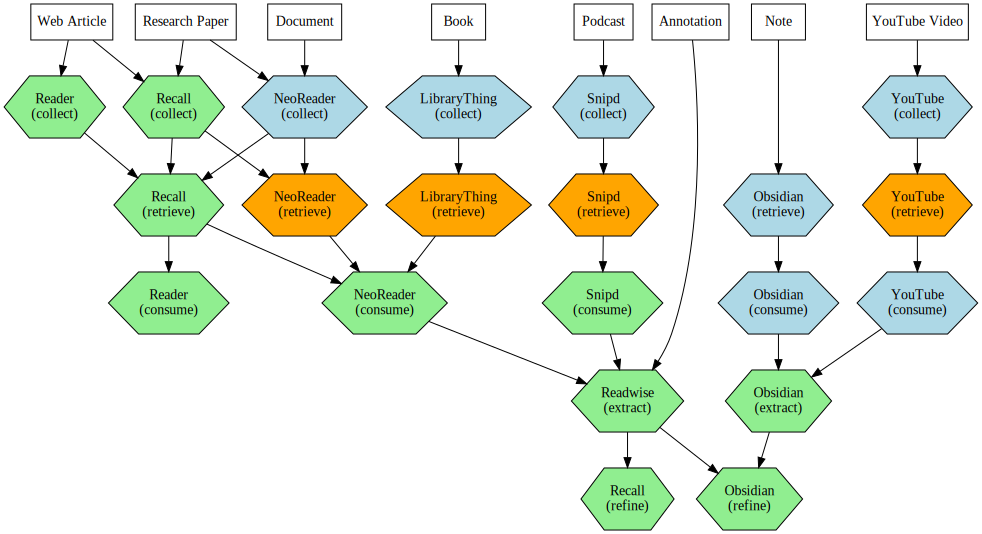

In [ ]:
viz

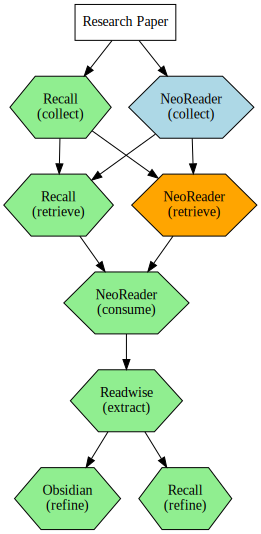

In [ ]:
viz_document = create_workflow_viz(items_inst['research_paper'])
viz_document

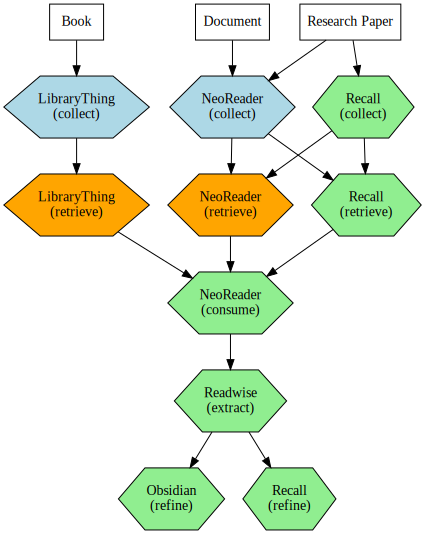

In [ ]:
viz_tool = create_workflow_viz(tool_filter='neoreader')
viz_tool

To get the `SVG` output, you can use the `_repr_image_svg_xml` method of the `Digraph` object. Below is an example showing the first 200 characters.

In [ ]:
viz._repr_image_svg_xml()[:200]

'<?xml version="1.0" encoding="UTF-8" standalone="no"?>\n<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"\n "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">\n<!-- Generated by graphviz version 2.43.0 (0)'

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()